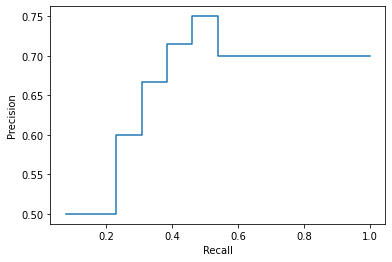

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import pandas as pd

from sklearn.metrics import PrecisionRecallDisplay

QRELS_FILE = "relevant.txt"
QUERY_URL = "http://localhost:8983/solr/music/select?q=name:love&wt=json"

relevant_list_attribute = "name"

# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(QRELS_FILE).readlines()))

# Get query results from Solr instance
results = requests.get(QUERY_URL).json()['response']['docs']


# METRICS TABLE

# Define custom decorator to automatically calculate metric based on key
metrics = {}


def metric(f):
    return metrics.setdefault(f.__name__, f)


@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = [len([doc for doc in results[:idx] if doc[relevant_list_attribute] in relevant]) / idx for idx in range(1, len(results))]

    return sum(precision_values) / len(precision_values)


@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc[relevant_list_attribute] in relevant]) / n


@metric
def recall(results, relevant):
    """Average Recall"""
    recall = len([doc for doc in results if doc[relevant_list_attribute] in relevant]) / len(relevant)

    return recall


@metric
def f_score(results, relevant):
    precision = len([doc for doc in results if doc[relevant_list_attribute] in relevant]) / len([doc for doc in results])

    recall = len([doc for doc in results if doc[relevant_list_attribute] in relevant]) / len(relevant)

    if precision + recall == 0:
        return 0

    return (2 * precision * recall) / (precision + recall)


def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)


# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)',
    'recall': 'Recall',
    'f_score': 'F-score/F-measure'
}

# Calculate all metrics and export results as LaTeX table
df = pd.DataFrame([['Metric', 'Value']] + [[evaluation_metrics[m], calculate_metric(m, results, relevant)] for m in evaluation_metrics])

with open('results.tex', 'w') as tf:
    tf.write(df.to_latex())


# PRECISION-RECALL CURVE

# Calculate precision and recall values as we move down the ranked list
precision_values = [len([doc for doc in results[:idx] if doc[relevant_list_attribute] in relevant]) / idx for idx, _ in enumerate(results, start=1)]
recall_values = [len([doc for doc in results[:idx] if doc[relevant_list_attribute] in relevant]) / len(relevant) for idx, _ in enumerate(results, start=1)]
precision_recall_match = {k: v for k, v in zip(recall_values, precision_values)}

# Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
recall_values.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values])
recall_values = sorted(set(recall_values))

# Extend matching dict to include these new intermediate steps
for idx, step in enumerate(recall_values):
    if step not in precision_recall_match:
        if recall_values[idx - 1] in precision_recall_match:
            precision_recall_match[step] = precision_recall_match[recall_values[idx - 1]]

        else:
            precision_recall_match[step] = precision_recall_match[recall_values[idx + 1]]

disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
disp.plot()
